# **Our understanding of the problem:**

Our objective is to optimize the trajectory of a landing plane, we start with an initial position, an initial speed and initial angles and we want to reach a final point in the airport, with a set of added constraints.

Our approach is to optimize the trajectory to use the less gaz as possible, so we try to minimize the gaz consuption during the landing period. 

To make the problem as easy as possible, we will first take into account the longitudinal equations and consider that our original position is in the axis of the landing runway. So, first, our plane will not have to turn. We will solve the optimization problem to minize the gaz consumption, which is our cost here. Our result will be a set of optimal inputs which are: the different control of the plane and the gaz power at each moment.

Later on, we can try to optimize a more complex trajectory, taking into account the lateral dynamics to make our model able to predict turns. We can also add some disturbances like wind to try to solve the problem step by step with an MPC.

We have all the equations of the plane in the longitudinal and lateral directions. Here they are: 

For the longitudinal part ▶
\begin{eqnarray}
\dot{v} &=& -\frac{S\rho}{2m}V²C_x + \frac{F}{m} - gγ\\
\dot{γ} &=& \frac{S\rho}{2m}VC_z - \frac{g}{V} \\
\dot{q} &=& \frac{Sl\rho}{2B}V²C_{m/g} \\
\dot{\alpha} &=& q-\dot{γ}\\
\dot{h} &=& vγ \nonumber\\
\dot{x} &=& v*cos(γ)\\
\end{eqnarray} 



with the following states
\begin{align}
X= \left[\begin{matrix}
v \\ \gamma \\ q \\ \alpha \\ h\\ x
\end{matrix}\right]
\end{align}

and the following inputs
\begin{align}
U= \left[\begin{matrix}
δ_x \\ \delta_m\
\end{matrix}\right]
\end{align}


where
\begin{align}
v &= \text{ air speed of the aircraft in m/s} \nonumber \\
\gamma &= \text{ slope angle in rad} \nonumber \\
q &= \text{ pitch speed in rad/s} \nonumber \\
\alpha &= \text{ angle of incidence in rad} \nonumber \\
h &= \text{ altitude in m} \nonumber \\
x &= \text{ position in the x axis in m} \nonumber \\
\delta_x &= \text{ gas power varying from 0 to 1} \nonumber \\
\delta_m &= \text{ pitch control in rad (angle of the elevator)} \nonumber \\
S &= \text{ 260 m²(wing surface)} \\
l &= \text{ 6.6 m (aerodynamic chord of the wing)} \\
m &= \text{ 110 000 kg (weight of the aircraft during a typical landing)} \\
B &= \text{ 9.72 .10^6 kg.m²(pitch inertia of the aircraft)} \\
\end{align}

# Final project - C231A

## Import libraries

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64


import matplotlib.pyplot as plt
import numpy as np 
import pyomo.environ as pyo

     |████████████████████████████████| 9.2 MB 5.1 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up 

## Problem parameters

In [ ]:
import math
# constants

S = 260 #m^2
l = 6.6 #m
m = 110000 #kg
rho_0 = 1.225 #kg/m^3
B = 9.72*10**6 #kg.m^2
Fmax = 120000 #N
Cxo = 0.0175
ki = 0.055
Cm0 = -0.1
Cmdm = -1.46
Cmq = -12
Cma = -1
Cza = 5
Czdm = 0.44
alpha_0 = -0.035
g = 9.81

Czq=0 #didn't find the data

def rho(h):
  return rho_0*(1-22.6*h*10**(-6))**4.26


# initial condition and terminal constraints
'''
Let's define typical initial conditions
'''
v0 = 125 #m/s
gam0=-3.5*math.pi/180 #rad - typical slope angle prior to landing
q0=0 #rad/s - pitch speed equal to zero during cruise
h0 = 1500 #m
alpha0= 2*m*g/(rho(h0)*v0**2*S*Cza) + alpha_0# Computed from the cruise equilibrium
print('initial incidence=',alpha0)
x0= 25*10**3 #m - let's say we start at x0 km from the landing site

z0Bar = np.array([v0,gam0,q0,alpha0,h0,x0])

'''
Let's define typical landing conditions
'''
hL=0

alpha_max=0.244 #data from the pdf - maximum angle of attack before stall
Vstall=math.sqrt(2*m*g/(rho(hL)*S*Cza*(alpha_max-alpha_0)))
print('Vstall=',Vstall)

vL=1.3*Vstall
gamL=0 #note that we will need to add a margin of error here. gama can't be exactly zero at landing otherwise the plane won't touch the ground but stay parallel to it
qL=0 # pretty much same thing than above, margin of error required

alphaL=2*m*g/(rho(hL)*vL**2*S*Cza) + alpha_0
print('landing incidence:', alphaL*180/math.pi)
xL=0

zNBar = np.array([vL,gamL,qL,alphaL,hL,xL])


# state and input constraints
xmin=xL
xmax=x0
vmin=Vstall
vmax=250
gamamax=10*math.pi/180
qmax=5*math.pi/180 #I clearly made this one up with a figure that seem reasonable
alphamin=alpha_0
alphamax=alpha_max
hmin=0
hmax=h0

zMin = np.array([vmin,-gamamax,-qmax,alphamin,hmin,xmin])
zMax = np.array([vmax,gamamax,qmax,alphamax,hmax,xmax])

dmax=30*math.pi/180

uMin = np.array([0., -dmax])
uMax = np.array([1., dmax])

print('zmin:',zMin)
print('zmax:',zMax)



initial incidence= 0.06546115140628836
Vstall= 69.69538507508709
landing incidence: 7.453536760917838
zmin: [ 6.96953851e+01 -1.74532925e-01 -8.72664626e-02 -3.50000000e-02
  0.00000000e+00  0.00000000e+00]
zmax: [2.50000000e+02 1.74532925e-01 8.72664626e-02 2.44000000e-01
 1.50000000e+03 2.50000000e+04]


In [ ]:
def solve_cftoc(Ts,N,W): 
  # number of states and inputs
  nz = 6
  nu = 2


  model = pyo.ConcreteModel()
  model.tidz = pyo.Set(initialize=range(0, N+1), ordered=True) # length of finite optimization problem
  model.zidz = pyo.Set(initialize=range(0, nz), ordered=True)
  model.uidz = pyo.Set(initialize=range(0, nu), ordered=True)

  # Create state and input variables trajectory:
  model.z = pyo.Var(model.zidz, model.tidz)
  model.u = pyo.Var(model.uidz, model.tidz)
  model.landing_gear = pyo.Var(model.tidz,domain = pyo.Binary)
  model.slats_flaps = pyo.Var(model.tidz,domain = pyo.Binary)
  
  #Original cost shown in class
  model.cost = pyo.Objective(expr = sum(model.u[0,t]**2 for t in range(0,N)), sense=pyo.minimize)

  #State initial conditions
  def initial_const_rule(model,i):
    return model.z[i,0]==z0Bar[i]
  model.initial_constraint=pyo.Constraint(model.zidz, rule=initial_const_rule)

  model.init_const_lg=pyo.Constraint(expr= model.landing_gear[0]==0)
  model.init_const_sf=pyo.Constraint(expr= model.slats_flaps[0]==0)

  #Dynamics
  model.constraint2 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts* ( -rho(model.z[4,t]) *model.z[0, t]**2*S/(2*m)* (Cxo+model.landing_gear[t]*0.0175+model.slats_flaps[t]*0.06 + ki*(Cza*(model.z[3, t]-(alpha_0+model.slats_flaps[t]*(-0.227))) + Czdm*model.u[1, t])**2 ) + (2*Fmax*model.u[0, t]*rho(model.z[4,t])/rho_0 )- g*model.z[1, t] )
                                     if t < N else pyo.Constraint.Skip)
  model.constraint3 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[1, t+1]*model.z[0, t] == model.z[1, t]*model.z[0, t] + Ts* ( rho(model.z[4,t]) *model.z[0, t]**2*S/(2*m)* (Cza*(model.z[3, t]-(alpha_0+model.slats_flaps[t]*(-0.227))) + Czdm*model.u[1, t])  - g )
                                     if t < N else pyo.Constraint.Skip)
  model.constraint4 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[2, t+1]*model.z[0,t] == model.z[2, t]*model.z[0,t] + Ts* (rho(model.z[4,t]) *model.z[0, t]**2*S*l/(2*B)* ((Cm0+model.slats_flaps[t]*(-0.3))*model.z[0,t] + Cma*(model.z[3, t]-(alpha_0+model.slats_flaps[t]*(-0.227)))*model.z[0,t] +Cmq*model.z[2,t]*l + Cmdm*model.u[1, t]*model.z[0,t] ))
                                     if t < N else pyo.Constraint.Skip)
  model.constraint5 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[3, t+1] == model.z[3, t] + Ts* (model.z[2, t] - (model.z[1, t+1]-model.z[1, t])/Ts)
                                     if t < N else pyo.Constraint.Skip)
  model.constraint6 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[4, t+1] == model.z[4, t] + Ts* (model.z[0, t]*model.z[1, t])
                                     if t < N else pyo.Constraint.Skip)
  model.constraint7 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[5, t+1] == model.z[5, t] - Ts* model.z[0,t]*pyo.cos(model.z[1,t])+Ts*W[t]
                                     if t < N else pyo.Constraint.Skip)

  #Constraints ##Please rename them starting from constraint 8

  model.constraint8 = pyo.Constraint(model.tidz, rule=lambda model, t: model.u[0, t] <=  uMax[0]
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint9 = pyo.Constraint(model.tidz, rule=lambda model, t: model.u[0, t] >= uMin[0]
                                     if t < N+1 else pyo.Constraint.Skip)

  model.constraint10 = pyo.Constraint(model.tidz, rule=lambda model, t: model.u[1, t] <= uMax[1]
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint11 = pyo.Constraint(model.tidz, rule=lambda model, t: model.u[1, t] >= uMin[1]
                                     if t < N+1 else pyo.Constraint.Skip)

  model.constraint12 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[0, t] <= zMax[0]
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint13 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[0, t] >= zMin[0] -21.189*model.slats_flaps[t]
                                     if t < N+1 else pyo.Constraint.Skip)

  model.constraint14 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[1, t] <= zMax[1] 
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint15 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[1, t] >= zMin[1] 
                                     if t < N+1 else pyo.Constraint.Skip)

  model.constraint16 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[2, t] <= zMax[2]
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint17 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[2, t] >= zMin[2]
                                     if t < N+1 else pyo.Constraint.Skip)

  model.constraint18 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[3, t] <= zMax[3]+0.07*model.slats_flaps[t]
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint19 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[3, t] >= zMin[3] -0.227*model.slats_flaps[t]
                                     if t < N+1 else pyo.Constraint.Skip)

  model.constraint20 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[4, t] <= zMax[4]
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint21 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[4, t] >= zMin[4] 
                                     if t < N+1 else pyo.Constraint.Skip)

  model.constraint22 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[5, t] <= zMax[5]
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint23 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[5, t] >= zMin[5] 
                                     if t < N+1 else pyo.Constraint.Skip)

  #decreasing altitude
  model.constraint_alt=pyo.Constraint(model.tidz, rule=lambda model, t: model.z[4,t+1]-model.z[4,t] <=0
                                     if t < N else pyo.Constraint.Skip)
  #limited acceleration
  model.constraint_acc1=pyo.Constraint(model.tidz, rule=lambda model, t: (model.z[0,t+1]-model.z[0,t])/Ts <=1*g
                                     if t < N else pyo.Constraint.Skip)
  model.constraint_acc2=pyo.Constraint(model.tidz, rule=lambda model, t: (model.z[0,t+1]-model.z[0,t])/Ts >=-1*g
                                     if t < N else pyo.Constraint.Skip)
  #landing gear
  model.constraint_lg = pyo.Constraint(model.tidz, rule=lambda model, t: model.landing_gear[t+1]>=model.landing_gear[t]
                                     if t < N else pyo.Constraint.Skip)
  model.constraint_lg1 = pyo.Constraint(model.tidz, rule=lambda model, t: model.landing_gear[t]>=0
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint_lg2 = pyo.Constraint(model.tidz, rule=lambda model, t: model.landing_gear[t]<=1
                                     if t < N+1 else pyo.Constraint.Skip)

  #Flaps and slats
  model.constraint_sf = pyo.Constraint(model.tidz, rule=lambda model, t: model.slats_flaps[t+1]>=model.slats_flaps[t]
                                     if t < N else pyo.Constraint.Skip)
  model.constraint_sf1 = pyo.Constraint(model.tidz, rule=lambda model, t: model.slats_flaps[t]>=0
                                     if t < N+1 else pyo.Constraint.Skip)
  model.constraint_sf2 = pyo.Constraint(model.tidz, rule=lambda model, t: model.slats_flaps[t]<=1
                                     if t < N+1 else pyo.Constraint.Skip)

  #Terminal constraints
  model.constraint24 = pyo.Constraint(expr= model.z[0, N] >=0.95*((W[N]*3.6/1.852)/2 + 63.05771570715261)) #computed landing speed with the slats/flaps extended
  model.constraint24bis = pyo.Constraint(expr= model.z[0, N] <=1.05*((W[N]*3.6/1.852)/2 + 63.05771570715261)) #due to the wind, regulatory safety margin is added to the air speed for the landing

  model.constraint25 = pyo.Constraint(expr= model.z[1, N] >= zNBar[1]-5*math.pi/180)
  model.constraint26 = pyo.Constraint(expr= model.z[1, N] <= zNBar[1]+5*math.pi/180) #I made that margin up, let's hope that it works
  model.constraint27 = pyo.Constraint(expr= model.z[2, N] >= zNBar[2]-5*math.pi/180)
  model.constraint28 = pyo.Constraint(expr= model.z[2, N] <= zNBar[2]+5*math.pi/180)#I made that margin up, let's hope that it works

  model.constraint29 = pyo.Constraint(expr= model.z[3, N] >= 0.07882840236686389*0.95) # computed landing incidence with the slats/flaps extended
  model.constraint29bis = pyo.Constraint(expr= model.z[3, N] <= 0.07882840236686389*1.05)
  model.constraint30 = pyo.Constraint(expr= model.z[4, N] >= zNBar[4])
  model.constraint30bis = pyo.Constraint(expr= model.z[4, N] <= zNBar[4]+10)
  model.constraint31 = pyo.Constraint(expr= model.z[5, N] >= zNBar[5])
  model.constraint31bis = pyo.Constraint(expr= model.z[5, N] <= zNBar[5]+100)

  model.constraint32=pyo.Constraint(expr= model.landing_gear[N]==1 )
  model.constraint33=pyo.Constraint(expr= model.slats_flaps[N]==1 )



  # Now we can solve:
  solver = pyo.SolverFactory('ipopt')
  solver.options['max_iter']= 3000
  results=solver.solve(model)
  results.write()

  feas=False
  if (results.solver.termination_condition == pyo.TerminationCondition.optimal): 
    feas=True

  return [feas,model,model.cost()]



In [ ]:
import random

results=[]
Ts=4
W0=random.uniform(0,20)
for i in range(10):
  W=[W0 for k in range(int((240+i*20)/Ts)+1)]
  [feasability, model, cost]=solve_cftoc(Ts,int( (240+i*20)/ Ts),W)
  if feasability==True:
    results.append([feasability, model, cost,W, (240+i*20)])

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1902
  Number of variables: 610
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 7.008934259414673
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==

In [ ]:
print(np.array(results))
model=results[0][1]
N=results[0][4]/Ts
W=results[0][3]


[[True
  7.433529354841707e-10
  list([16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 16.897233109920492, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
# plot results
z1_a = [pyo.value(model.z[0,0])]
z2_a = [pyo.value(model.z[1,0])]
z3_a = [pyo.value(model.z[2,0])]
z4_a = [pyo.value(model.z[3,0])]
z5_a = [pyo.value(model.z[4,0])]
z6_a = [pyo.value(model.z[5,0])]

u1_a = [pyo.value(model.u[0,0])]
u2_a = [pyo.value(model.u[1,0])]

LG=[pyo.value(model.landing_gear[0])]
SF=[pyo.value(model.slats_flaps[0])]

TFinal = Ts*N

for t in model.tidz:
    if t < N:
        z1_a.append(pyo.value(model.z[0,t+1]))
        z2_a.append(pyo.value(model.z[1,t+1]))
        z3_a.append(pyo.value(model.z[2,t+1]))
        z4_a.append(pyo.value(model.z[3,t+1]))
        z5_a.append(pyo.value(model.z[4,t+1]))
        z6_a.append(pyo.value(model.z[5,t+1]))
        LG.append(pyo.value(model.landing_gear[t+1]))
        SF.append(pyo.value(model.slats_flaps[t+1]))
    if t < N-1:
        u1_a.append(pyo.value(model.u[0, t+1]))
        u2_a.append(pyo.value(model.u[1,t+1]))

T = np.linspace(0.,TFinal,len(z1_a))

print('speed:',z1_a)
print('slope:',z2_a)
print('pitch speed:',z3_a)
print('incidence:',z4_a)
print('altitude:',z5_a)
print('distance to runway:',z6_a)

print('manette des gaz:',u1_a)
print('profondeur:',u2_a)

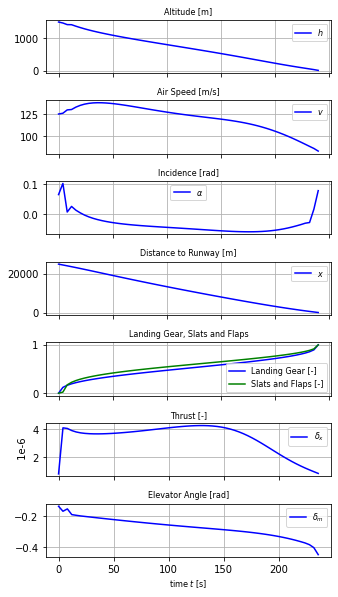

In [ ]:
figsize = (10/2.5, 3/2.5)
figsize_subplots = (12/2.5, 7* 3/2.5)
fontsize = 8
fig, ax = plt.subplots(7, 1, figsize = figsize_subplots)

#ax[0].set_title('States', fontsize = fontsize +2)
ax[0].set_title("Altitude [m]", fontsize = fontsize)
ax[0].plot(T, z5_a, 'b')
ax[0].legend([r"$h$"], fontsize = fontsize)
ax[0].set_xticklabels([])
ax[0].grid()

ax[1].plot(T, z1_a, 'b')
ax[1].set_title("Air Speed [m/s]", fontsize = fontsize)
ax[1].legend([r"$v$"], fontsize = fontsize)
ax[1].set_xticklabels([])
ax[1].grid()

ax[2].plot(T, z4_a, 'b')
ax[2].set_title(r"Incidence [rad]", fontsize = fontsize)
ax[2].legend([r"$\alpha$"], fontsize = fontsize)
ax[2].set_xticklabels([])
ax[2].grid()

ax[3].plot(T, z6_a, 'b')
ax[3].set_title(r"Distance to Runway [m]", fontsize = fontsize)
ax[3].legend([r"$x$"], fontsize = 8)
ax[3].set_xticklabels([])
ax[3].grid()

ax[4].plot(T, LG, 'b')
ax[4].plot(T, SF, 'g')
ax[4].set_title(r"Landing Gear, Slats and Flaps", fontsize = fontsize)
ax[4].legend(["Landing Gear [-]", "Slats and Flaps [-]"], fontsize = 8)
ax[4].set_xticklabels([])
ax[4].grid()

#ax[5].set_title('Control Inputs', fontsize = fontsize +2)
ax[5].plot(T[:-1], u1_a, 'b')
ax[5].set_title(r"Thrust [-]", fontsize = fontsize)
ax[5].legend([r"$\delta_x$"], fontsize = 8)
ax[5].set_xticklabels([])
ax[5].grid()
ax[5].yaxis.offsetText.set_visible(False)
ax[5].yaxis.set_label_text(" 1e-6") # control if this is correct!

ax[6].plot(T[:-1], u2_a, 'b')
ax[6].set_title(r"Elevator Angle [rad]", fontsize = fontsize)
ax[6].legend([r"$\delta_m$"], fontsize = 8)
ax[6].grid()
ax[6].set_xlabel(r'time $t$ [s]', fontsize = fontsize)

fig.tight_layout()
fig.savefig('windv2.pdf')

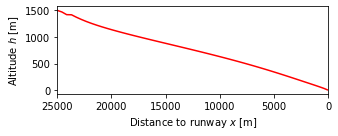

In [ ]:
# landing trajectory

fig2 = plt.figure(figsize= (12/2.5, 5/2.5))
ax1 = plt.gca()
plt.xlabel(r'Distance to runway $x$ [m]')
plt.ylabel(r'Altitude $h$ [m]')
#plt.title('Landing trajectory')
plt.plot(z6_a,z5_a, color='red')
ax1.invert_xaxis()
plt.xlim(25000,0)
plt.ylim=(0,1500)
fig2.tight_layout()
plt.show()
fig2.savefig('windv2_trajec.pdf')

In [ ]:
fig0 = plt.figure(figsize=figsize)
plt.plot(T, W,'b')
plt.xlabel('time [s]')
#plt.ylabel(r'Front wind speed [m/s]')
plt.title(r'Front wind speed [m/s]')


fig1 = plt.figure(figsize=figsize)
plt.plot(T, z5_a,'b')
#plt.xlabel('time [s]')
#plt.ylabel(r'Height [m]')
plt.title('Altitude [m]')


fig2=plt.figure(figsize=(8,5))
plt.plot(T, z6_a,'b')
plt.xlabel('time [s]')
plt.ylabel('x [m]')
plt.title(r'Time evolution of the longitudinal position')

fig3=plt.figure(figsize=(8,5))
plt.plot(T, z4_a,'b')
plt.xlabel('time [s]')
plt.ylabel('incidence [rad]')
plt.title(r'Time evolution of the incidence')

fig4=plt.figure(figsize=(8,5))
plt.plot(T, z1_a,'b')
plt.xlabel('time [s]')
plt.ylabel('speed [m/s]')
plt.title(r'Time evolution of the speed')

fig5=plt.figure(figsize=(8,5))
plt.plot(T, LG,'b')
plt.xlabel('time [s]')
plt.ylabel('landing gear status')
plt.title(r'Time evolution of the LG')

fig6=plt.figure(figsize=(8,5))
plt.plot(T, SF,'b')
plt.xlabel('time [s]')
plt.ylabel('Slats and flaps status')
plt.title(r'Time evolution of the SF')


fig2 = plt.figure(figsize=(8,10))

bx = fig2.add_subplot(211,autoscale_on=True)
bx.plot(T[:-1], u1_a,'b')
bx.set_xlabel('time [s]')
bx.set_ylabel('delta_x')
bx.title.set_text(r'Time evolution of the thrust')


bx = fig2.add_subplot(212,autoscale_on=True)
bx.plot(T[:-1], u2_a,'b')
bx.set_xlabel('time [s]')
bx.set_ylabel(r'$\delta$ [rad]')
bx.title.set_text(r'Time evolution of the elevator angle')


plt.show()

plt.figure(figsize=(15,4))
plt.xlabel('Distance to the runway [m]')
plt.ylabel('Altitude [m]')
plt.title('Landing trajectory')
plt.plot(z6_a,z5_a, color='red')
plt.xlim(0,25000)
plt.ylim=(0,1800)